# CSCK506 Deep Learning Group Project
To train a *Convolutional Neural Network* (CNN) model to be able to detect healthy lungs from pneumonia infected ones.

Table of Contents
=================
1. [Import Libraries](#Import-Libraries)
2. [Data Preprocessing](#Data-Preprocessing)
    1. [Load Data](#Load-Data)
    2. [Understanding the Data](#Understanding-the-Data)
    3. [Data Visualization](#Data-Visualization)
    4. [Check for Imbalance Data](#Check-for-Imbalance-Data)
    5. [Data Augmentation](#Data-Augmentation)
    6. [Dataloader for Batching](#Dataloader-for-Batching)
 3. [Model Development](#Model-Development)
    1. [Build the CNN Model](#Build-the-CNN-Model)
    2. [Train the CNN Model](#Train-the-CNN-Model)
    3. [Evaluate the CNN Model](#Evaluate-the-CNN-Model)
    4. [Save the CNN Model](#Save-the-CNN-Model)
 4. [Model Testing](#Model-Testing)
    1. [Load the CNN Model](#Load-the-CNN-Model)
    2. [Test the CNN Model](#Test-the-CNN-Model)

## Import Libraries

In [1]:
import os
import hashlib
import zipfile
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.10.1


In [2]:
# Test GPU availability
if tf.test.gpu_device_name() == '/device:GPU:0':
    tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

## Data Preprocessing

### Unzip File into data folder
- Download the dataset from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) and extract it to the same directory as this notebook.
- To re-extract the dataset, delete the data folder and run the following code.

In [3]:
if not os.path.exists('data'):
    DATA_EXIST = False
    os.makedirs('data')
else:
    DATA_EXIST = True
    EXTRACT_FROM_ZIP = False
    print('Data folder already exists')

# Check if downloaded data is correct
FILENAME = 'archive.zip'
SHA256SUM ='f569fe885b0f921e836f3d6bcc8d7b3442f5e0ca4db4533d06b8cf25d2114ea1'

if os.path.exists(FILENAME) and not DATA_EXIST:
    with open(FILENAME, 'rb') as f:
        read_bytes = f.read() # read entire file as bytes
        READABLE_HASH = hashlib.sha256(read_bytes).hexdigest()
        if READABLE_HASH != SHA256SUM:
            print('Data corrupted, please download again')
            os.remove(FILENAME)
            EXTRACT_FROM_ZIP = False
        else:
            EXTRACT_FROM_ZIP = True # Ready to extract data from zip file

folder_to_extract = ['chest_xray/test', 'chest_xray/train', 'chest_xray/val']

# Extract data from zip file
if not DATA_EXIST and EXTRACT_FROM_ZIP:
    with zipfile.ZipFile(FILENAME, 'r') as zip_ref:
        for fol in folder_to_extract:
            for file in zip_ref.namelist():
                if file.startswith(fol):
                    zip_ref.extract(file, 'data')
    for fol in folder_to_extract:
        os.rename('data/'+fol, 'data/'+fol.split('/')[1])
    os.rmdir('data/chest_xray')

Data folder already exists


### Load the Data

In [4]:
# Set data directory
train_dir = 'data/train'
test_dir = 'data/test'
val_dir = 'data/val'

# labels
labels = ['NORMAL', 'PNEUMONIA']


In [5]:
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
if not os.path.exists('logs'):
    os.makedirs('logs')

### Understanding the Data

In [6]:
# Plot the number of images per class in a dataset
def plot_num_images_per_class(data_dir, labels, title='Number of images per class'):
    """
    Plot the number of images per class in a dataset
    
    Args:
        data_dir: directory of the dataset
        labels: list of labels
        title: title of the plot

    Returns:
        num_images: plot of the number of images per class
        ratio: ratio of images per class
    """
    num_images = []
    ratio = {}
    print(title)
    for label in labels:
        count = len(os.listdir(os.path.join(data_dir, label)))
        num_images.append(count)
    
    print(f'Total: {sum(num_images)}')

    for i in range(len(labels)):
        ratio[labels[i]] = num_images[i]/sum(num_images)
        print(f'{labels[i]}: {num_images[i]} ({ratio[labels[i]]*100:.2f}%)')

    plt.bar(labels, num_images)
    plt.title(title)
    plt.show()
    return num_images, ratio

# Plot the number of images in each dataset
def plot_num_images_per_dataset(train_num_images, test_num_images, val_num_images):
    """
    Plot the number of images in each dataset

    Args:
        train_num_images: number of images per class in train dataset
        test_num_images: number of images per class in test dataset
        val_num_images: number of images per class in val dataset

    Returns:
        num_images: plot of the number of images in each dataset
        ratio: ratio of images in each dataset
    """
    num_images = [sum(train_num_images), sum(test_num_images), sum(val_num_images)]
    # ratio of images in each dataset
    ratio = {'train': num_images[0]/sum(num_images), 'test': num_images[1]/sum(num_images), 'val': num_images[2]/sum(num_images)}
    for i in range(3):
        print(f'{["train", "test", "val"][i]}: {num_images[i]} ({ratio[["train", "test", "val"][i]]*100:.2f}%)')
    plt.bar(['train', 'test', 'val'], num_images)
    plt.title('Number of images per dataset')
    plt.show()
    return num_images, ratio

# Plot the pixel distribution of images in a dataset
def plot_pixel_distribution(data_dir, labels, title='Pixel distribution'):
    """
    Plot the pixel distribution of images in a dataset

    Args:
        data_dir: directory of the dataset
        labels: list of labels
        title: title of the plot

    Returns:
        pixel_distribution: plot of the pixel distribution of images in a dataset
    """
    pixel_distribution = []
    print(title)
    for label in labels:
        for file in os.listdir(os.path.join(data_dir, label)):
            img = tf.keras.preprocessing.image.load_img(os.path.join(data_dir, label, file))
            img = tf.keras.preprocessing.image.img_to_array(img)
            pixel_distribution.append(img.shape[0])
            pixel_distribution.append(img.shape[1])
    plt.hist(pixel_distribution, bins=100)
    plt.title(title)
    plt.show()
    return pixel_distribution

Number of images per class in train dataset
Total: 5216
NORMAL: 1341 (25.71%)
PNEUMONIA: 3875 (74.29%)


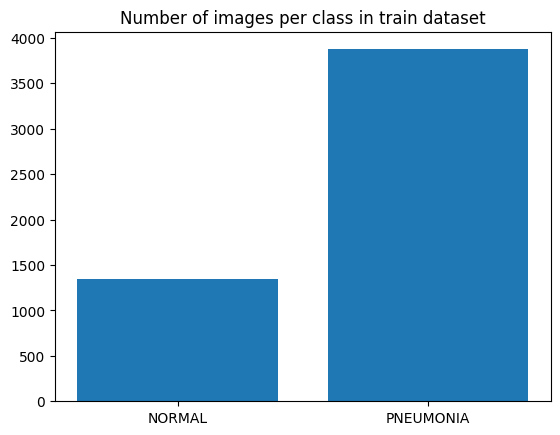

Number of images per class in test dataset
Total: 624
NORMAL: 234 (37.50%)
PNEUMONIA: 390 (62.50%)


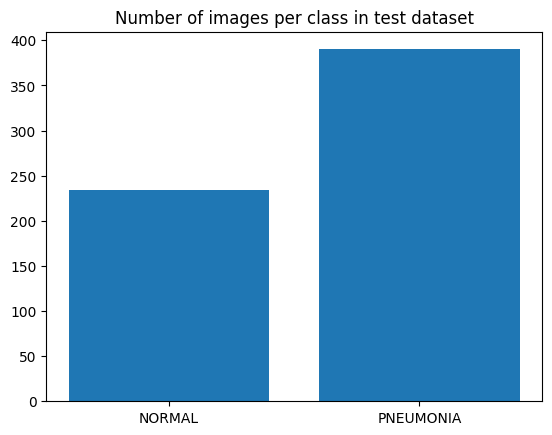

Number of images per class in val dataset
Total: 16
NORMAL: 8 (50.00%)
PNEUMONIA: 8 (50.00%)


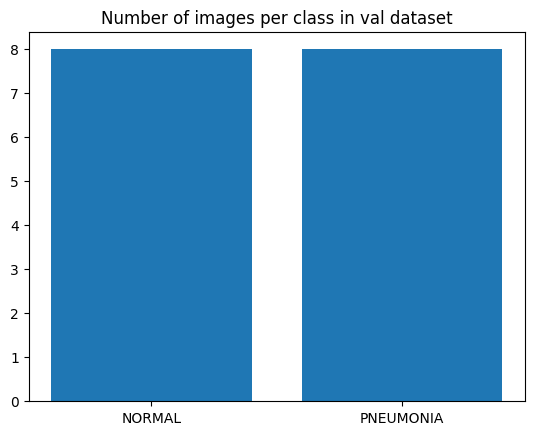

train: 5216 (89.07%)
test: 624 (10.66%)
val: 16 (0.27%)


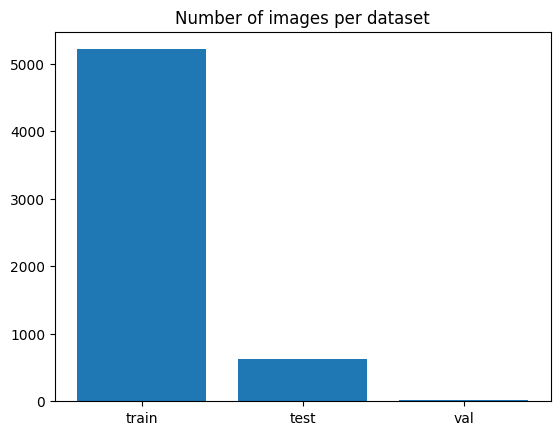

In [7]:
train_num_images, train_ratio = plot_num_images_per_class(train_dir, labels, title='Number of images per class in train dataset')
test_num_images, test_ratio = plot_num_images_per_class(test_dir, labels, title='Number of images per class in test dataset')
val_num_images, val_ratio = plot_num_images_per_class(val_dir, labels, title='Number of images per class in val dataset')
num_images, tts_ratio = plot_num_images_per_dataset(train_num_images, test_num_images, val_num_images)

Pixel distribution in train dataset


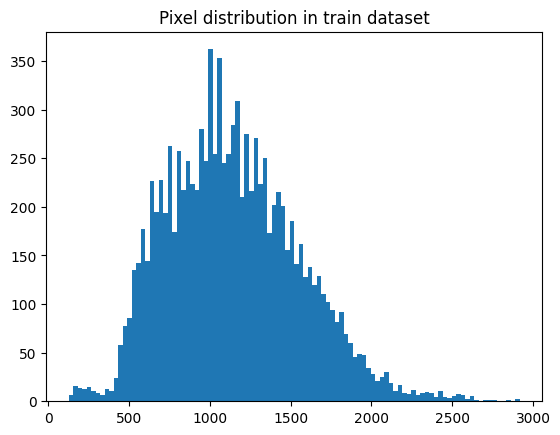

2916 127


In [8]:
# Obtain the pixel distribution of images in each dataset to determine the best image size for training
train_pixel_distribution = plot_pixel_distribution(train_dir, labels, title='Pixel distribution in train dataset')
print(max(train_pixel_distribution), min(train_pixel_distribution))

### Adjust for Imbalance Data by calculating class weights
From the graph above, we can see that the data is imbalanced. To solve this problem, we will calculate the class weights and use it in the loss function.
The normal class will have a higher weight than the pneumonia class, as there are more pneumonia images than normal images.

In [9]:
normal_weight = 1/train_ratio['NORMAL']
pneumonia_weight = 1/train_ratio['PNEUMONIA']
class_weight = {0: normal_weight, 1: pneumonia_weight}
print(f'Class weight: {class_weight}')

Class weight: {0: 3.889634601043997, 1: 1.3460645161290323}


### Dataloader for Batching
Load the data into batches of images and labels using PyTorch's DataLoader class.

In [10]:
dataloader_params = {'labels': 'inferred',
                     'label_mode': 'binary',
                     'class_names': labels,
                     'color_mode': 'grayscale', # x-ray images are grayscale
                     'batch_size': 16,
                     'image_size': (256, 256),
                     'crop_to_aspect_ratio': False, # not cropping images to preserve details, albeit with distortion
                     }
train_data = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, **dataloader_params)
val_data = tf.keras.utils.image_dataset_from_directory(val_dir, shuffle=False, **dataloader_params) # as there are only 16 images in val dataset, no need to shuffle

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [11]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [12]:
batch_img, batch_label = next(train_data.as_numpy_iterator())
print(f'Batch image shape: {batch_img.shape}, batch label shape: {batch_label.shape}')
batch_img.max(), batch_img.min()

Batch image shape: (16, 256, 256, 1), batch label shape: (16, 1)


(255.0, 0.0)

### Data Visualization

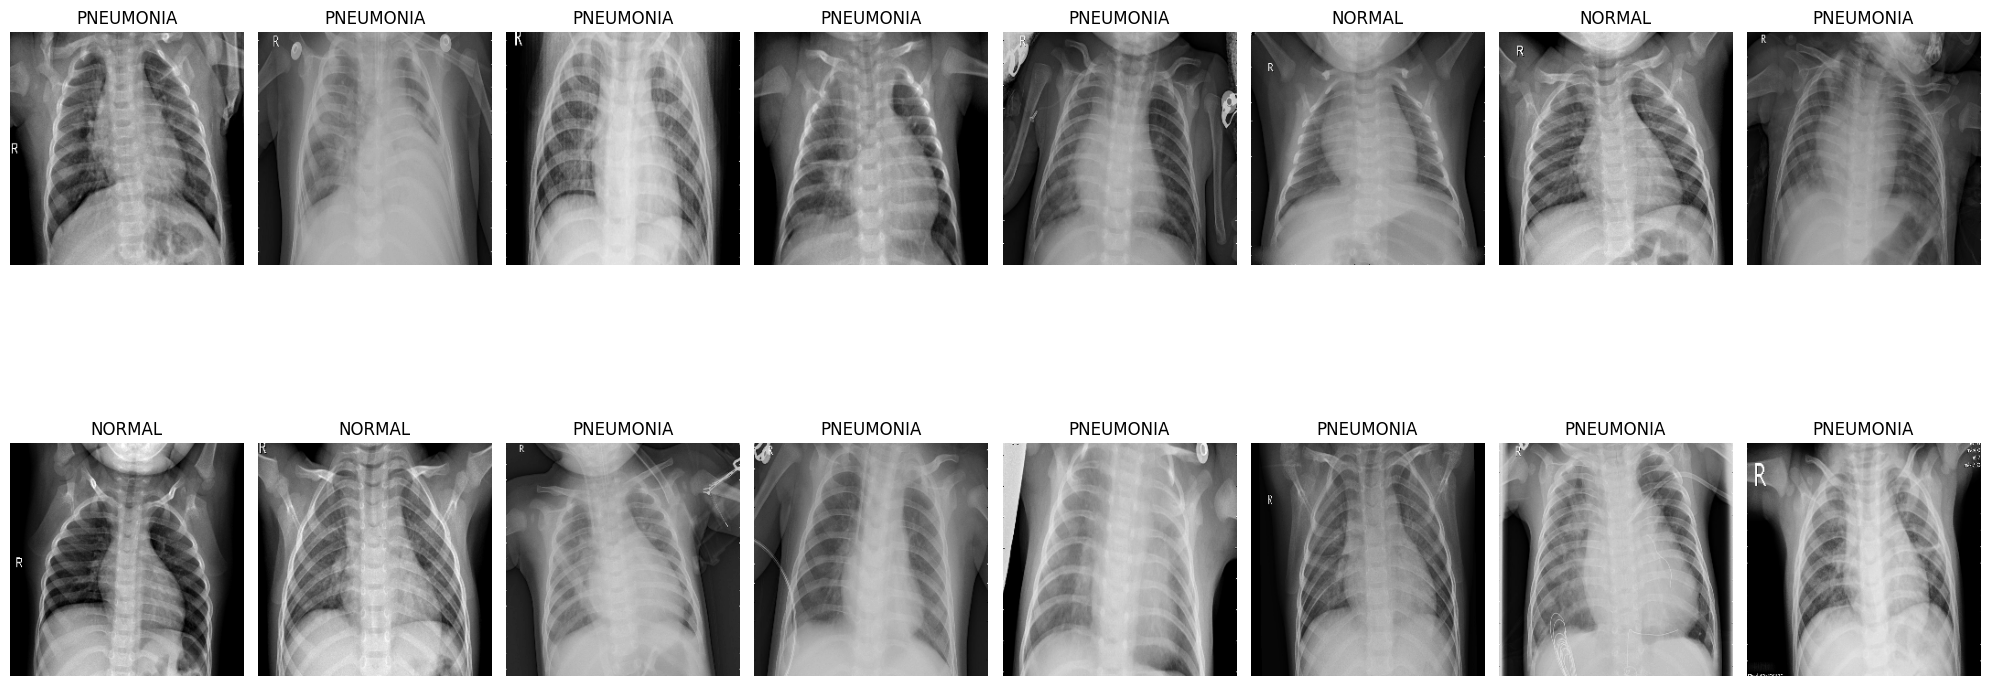

In [13]:
# Visualize batch
row, col = 2, 8
fig, axes = plt.subplots(row, col, figsize=(20, 10))
axes = axes.flatten()
for img, label, ax in zip(batch_img, batch_label, axes):
    ax.imshow(img[:,:,0], cmap='gray')
    ax.set_title(labels[int(label)])
    ax.axis('off')
plt.tight_layout()

### Data Normalization

In [14]:
# Rescale pixel values to [0,1] from [0,255]
print(f'Before rescaling: {batch_img.max()}, {batch_img.min()}')
train_data = train_data.map(lambda x, y: (x/255, y))
val_data = val_data.map(lambda x, y: (x/255, y))
batch_img, batch_label = next(train_data.as_numpy_iterator())
print(f'After rescaling: {batch_img.max()}, {batch_img.min()}')

Before rescaling: 255.0, 0.0
After rescaling: 1.0, 0.0


#### Data Augmentation
Alter the training data with the following transformations:
- Randomly rotate some training images by a factor of 2pi
- Randomly zoom some training images

The purpose of data augmentation is to improve the performance and ability of the model to generalize, invariant to the changes in the input data.

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation((-0.03,0.03)),
    tf.keras.layers.RandomZoom(0.1),
])
train_data = train_data.map(lambda x, y: (data_augmentation(x), y))

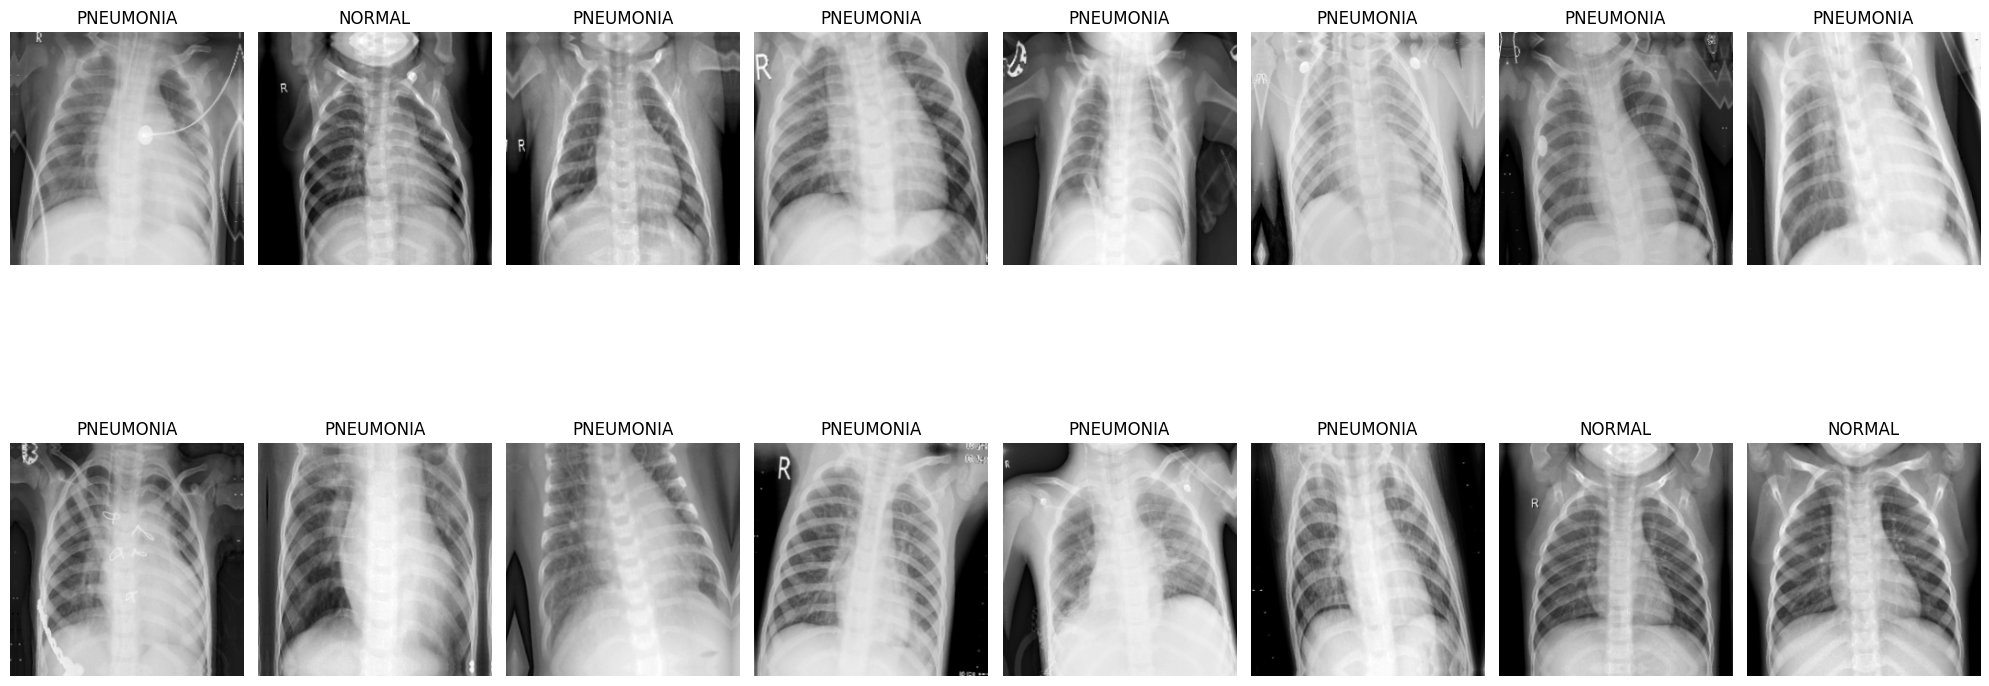

In [16]:
# Visualize batch
batch_img, batch_label = next(train_data.as_numpy_iterator())
row, col = 2, 8
fig, axes = plt.subplots(row, col, figsize=(20, 10))
axes = axes.flatten()
for img, label, ax in zip(batch_img, batch_label, axes):
    ax.imshow(img[:,:,0], cmap='gray')
    ax.set_title(labels[int(label)])
    ax.axis('off')
plt.tight_layout()

In [17]:
# shape of train, test, val data
print(f'Train data shape: {train_data.element_spec}')
print(f'Val data shape: {val_data.element_spec}')

print(f'Batch shape: {batch_img.shape}')
print(f'Label shape: {batch_label.shape}')

input_shape = batch_img.shape[1:]
print(f'Input shape: {input_shape}')

Train data shape: (TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
Val data shape: (TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
Batch shape: (16, 256, 256, 1)
Label shape: (16, 1)
Input shape: (256, 256, 1)


## Model Development

### Build the CNN Model
Use the training data to train the model with CNN which has the minimum loss and maximum accuracy for detecting the images with pneumonia.

#### Training Preparation

In [18]:
# Training optimization with autotune to determine the best number of parallel calls
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

### Train the CNN Model
Choose:
- Number of convolution-pooling building blocks,
- The strides, padding and activation function that give you the maximum accuracy, --> Hyperparameter tuning
- A solution to avoid overfitting problem in your code. --> Regularization

In [19]:
# Build the model
def build_model(input_shape, output_shape, model_name='xray_model', dropout_rate=0.2, format='channels_last', stride=(1,1), pad='valid', act='relu'):
    """
    Build a convolutional neural network model for image classification.

    Args:
        input_shape (tuple): Shape of the input image.
        output_shape (int): Number of classes in the dataset.
        model_name (str): Name of the model.
        dropout_rate (float): Dropout rate.
        format (str): Format of the input image.
        stride (tuple): Stride of the convolutional layers.
        pad (str): Padding of the convolutional layers.
        act (str): Activation function of the convolutional layers and the fc layer.

    Returns:
        model (tf.keras.Sequential): A convolutional neural network model.
    """
    model = tf.keras.Sequential([
        # Initialize the input layer with the input shape
        tf.keras.layers.Conv2D(32, 3, strides=stride, padding=pad, activation=act, input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        # Middle convolutional layers to extract features
        tf.keras.layers.Conv2D(64, 3, strides=stride, padding=pad, activation=act),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        # Last convolutional layers to extract higher level features
        tf.keras.layers.Conv2D(128, 3, strides=stride, padding=pad, activation=act),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        # Flatten the output of the convolutional layers
        tf.keras.layers.Flatten(),
        # Add a fully connected layer to classify the images
        tf.keras.layers.Dense(128, activation=act),
        # Add a dropout layer to prevent overfitting
        tf.keras.layers.Dropout(dropout_rate),
        # Add the output layer
        tf.keras.layers.Dense(output_shape, activation='sigmoid')
    ], name=model_name)
    return model

def compile_model(model, optimizer='adam', loss='binary_crossentropy', model_metrics=['accuracy']):
    """
    Compile the model

    Args:
        model: model
        optimizer: optimizer
        loss: loss function
        metrics: metrics

    Returns:
        model: compiled model
    """
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=model_metrics)
    return model

def train_model(model, train_data, val_data, epochs=10, callbacks=None, class_weight=None):
    """
    Train the model

    Args:
        model: model
        train_data: train data
        val_data: validation data
        epochs: number of epochs
        verbose: verbose
        callbacks: callbacks
        class_weight: class weight

    Returns:
        history: training history
    """
    history = model.fit(train_data,
                        validation_data=val_data,
                        class_weight=class_weight,
                        epochs=epochs,
                        callbacks=callbacks)
    return history

def callbacks(model_name, checkpoint_path, patience=10):
    """
    Create callbacks for the model

    Args:
        model_name: model name
        checkpoint_path: checkpoint path
        patience: patience

    Returns:
        callbacks: callbacks
    """
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_best_only=True)
    # Create a callback that stops the training when the validation loss does not improve
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience,
                                                      restore_best_weights=True)
    # Create a callback that logs the TensorBoard
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f'logs/{model_name}', histogram_freq=1)
    callbacks = [cp_callback, early_stopping, tensorboard_callback]
    return callbacks

In [20]:
# Set the hyperparameters for the model
num_epochs = 3
model_name = 'CNN-1x1-valid-relu-3'
checkpoint_path = f'checkpoints/{model_name}.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
model_metrics = ['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [21]:
# Build and compile the model
model = build_model(input_shape, output_shape=1, model_name=model_name)
model = compile_model(model, optimizer=optimizer, model_metrics=model_metrics)
model_callbacks = callbacks(model_name, checkpoint_path)
print(model.summary())

Model: "CNN-1x1-valid-relu-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                              

In [22]:
# Train the model
history = train_model(model, train_data, val_data, epochs=num_epochs, callbacks=model_callbacks, class_weight=class_weight)

Epoch 1/3
326/326 [==============================] - 17s 41ms/step - loss: 2.2141 - accuracy: 0.8725 - precision: 0.9395 - recall: 0.8854 - val_loss: 51.2616 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/3
326/326 [==============================] - 9s 28ms/step - loss: 0.6244 - accuracy: 0.8871 - precision: 0.9597 - recall: 0.8852 - val_loss: 0.4368 - val_accuracy: 0.8750 - val_precision: 1.0000 - val_recall: 0.7500
Epoch 3/3
326/326 [==============================] - 9s 27ms/step - loss: 0.5417 - accuracy: 0.8901 - precision: 0.9744 - recall: 0.8751 - val_loss: 0.3199 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750


In [23]:
model.metrics_names

['loss', 'accuracy', 'precision', 'recall']

### Evaluate and Tune the CNN Model
Tune the hyperparameters to get the best accuracy.

In [24]:
# Hyperparameter tuning
# Set the hyperparameters for the model
HP_STRIDE = hp.HParam('stride', hp.Discrete([1, 2]))
HP_PAD = hp.HParam('pad', hp.Discrete(['same', 'valid']))
HP_ACT = hp.HParam('act', hp.Discrete(['relu', 'sigmoid']))

# Set the metrics to log for the hyperparameter tuning
METRIC_ACCURACY = 'accuracy'
METRIC_PRECISION = 'precision'
METRIC_RECALL = 'recall'
VALIDATION_ACCURACY = 'val_accuracy'
VALIDATION_PRECISION = 'val_precision'
VALIDATION_RECALL = 'val_recall'

# Configure the hyperparameter tuning logs
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_STRIDE, HP_PAD, HP_ACT],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='accuracy'),
                 hp.Metric(METRIC_PRECISION, display_name='precision'),
                 hp.Metric(METRIC_RECALL, display_name='recall'),
                 hp.Metric(VALIDATION_ACCURACY, display_name='val_accuracy'),
                 hp.Metric(VALIDATION_PRECISION, display_name='val_precision'),
                 hp.Metric(VALIDATION_RECALL, display_name='val_recall')],
    )

In [25]:
model_val_accuracy = {}
# Grid search
for stride in HP_STRIDE.domain.values:
    for pad in HP_PAD.domain.values:
        for act in HP_ACT.domain.values:
            # Record hyperparameters
            hparams = {
                HP_STRIDE: stride,
                HP_PAD: pad,
                HP_ACT: act
            }
            
            # Number of epochs for hyperparameter tuning
            num_epochs = 10
            # Set the input stride
            input_stride = (stride, stride)
            
            # Set the run variables
            model_name = f'CNN-{stride}x{stride}-{pad}-{act}-{num_epochs}'
            checkpoint_path = f'checkpoints/{model_name}.h5'
            checkpoint_dir = os.path.dirname(checkpoint_path)
            model_metrics = ['accuracy',
                             tf.keras.metrics.Precision(name='precision'),
                             tf.keras.metrics.Recall(name='recall')]
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

            # Build, compile and train the model
            model = build_model(input_shape, output_shape=1, model_name=model_name, stride=input_stride, pad=pad, act=act)
            model = compile_model(model, optimizer=optimizer, model_metrics=model_metrics)
            model_callbacks = callbacks(model_name, checkpoint_path)
            history = train_model(model, train_data, val_data, epochs=num_epochs, callbacks=model_callbacks, class_weight=class_weight)

            # Save the metrics to variables
            accuracy = history.history['accuracy'][-1]
            precision = history.history['precision'][-1]
            recall = history.history['recall'][-1]
            val_accuracy = history.history['val_accuracy'][-1]
            val_precision = history.history['val_precision'][-1]
            val_recall = history.history['val_recall'][-1]

            # Save the best model based on the validation accuracy
            if model_name not in model_val_accuracy:
                model_val_accuracy[model_name] = val_accuracy
        
            # Log the metrics
            with tf.summary.create_file_writer('logs/hparam_tuning/'+model_name).as_default():
                hp.hparams(hparams, trial_id=model_name)
                tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
                tf.summary.scalar(METRIC_PRECISION, precision, step=1)
                tf.summary.scalar(METRIC_RECALL, recall, step=1)
                tf.summary.scalar(VALIDATION_ACCURACY, val_accuracy, step=1)
                tf.summary.scalar(VALIDATION_PRECISION, val_precision, step=1)
                tf.summary.scalar(VALIDATION_RECALL, val_recall, step=1)

Epoch 1/10
326/326 [==============================] - 10s 28ms/step - loss: 3.5931 - accuracy: 0.8859 - precision: 0.9568 - recall: 0.8865 - val_loss: 14.1126 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 2/10
326/326 [==============================] - 9s 28ms/step - loss: 0.3810 - accuracy: 0.9411 - precision: 0.9750 - recall: 0.9450 - val_loss: 3.1603 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 3/10
326/326 [==============================] - 9s 28ms/step - loss: 0.3385 - accuracy: 0.9482 - precision: 0.9745 - recall: 0.9554 - val_loss: 0.4034 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 4/10
326/326 [==============================] - 9s 27ms/step - loss: 0.3008 - accuracy: 0.9498 - precision: 0.9755 - recall: 0.9564 - val_loss: 3.7015 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 5/10
326/326 [==============================] - 9s 27ms/step - loss: 0.2752 - accuracy: 0.95

## Model Testing

### Load the CNN Model

In [31]:
# Load best model from hyperparameter tuning on validation accuracy
model_name = max(model_val_accuracy, key=model_val_accuracy.get)
print(f'Best model: {model_name}')
checkpoint_path = f'checkpoints/{model_name}.h5'
model = tf.keras.models.load_model(checkpoint_path)

Best model: CNN-2x2-valid-relu-10


### Test the CNN Model
Use the test dataset after the final tuning to obtain the maximum test accuracy

#### Load Test Data from directory

In [27]:
# Get data and labels on the test set
test_data = []
true_labels = []
img_height, img_width = 256, 256

for label in labels:
    for img_path in (os.listdir(f'{test_dir}/{label}')):
        img = tf.keras.preprocessing.image.load_img(f'{test_dir}/{label}/{img_path}', color_mode='grayscale')
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.image.resize(img, (img_height, img_width))
        img = img/255.0
        test_data.append(img)
        true_labels.append(label)

test_data = np.array(test_data)
true_labels = np.array(true_labels)
true_labels = np.where(true_labels=='PNEUMONIA', 1, 0)
print(f'Test data shape: {test_data.shape}')
print(f'True labels shape: {true_labels.shape}')

Test data shape: (624, 256, 256, 1)
True labels shape: (624,)


#### Confusion Matrix

In [28]:
# visualize confusion matrix
def plot_confusion_matrix(model, test_data, true_labels, labels=['NORMAL', 'PNEUMONIA']):
    """
    Plot the confusion matrix

    Args:
        model: model
        test_data: test data
        true_labels: true labels
        labels: labels
    
    Returns:
        None
    """
    y_pred = model.predict(test_data)
    y_pred = np.where(y_pred > 0.5, 1, 0)

    cm = confusion_matrix(true_labels, y_pred)
    cm_labels = np.asarray([['TN', 'FP'], ['FN', 'TP']])
    annotations = np.asarray([f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(cm.flatten(), cm_labels.flatten(), np.round(cm.flatten()/np.sum(cm),4))]).reshape(2,2)
    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels)
    return None

20/20 [==============================] - 0s 7ms/step


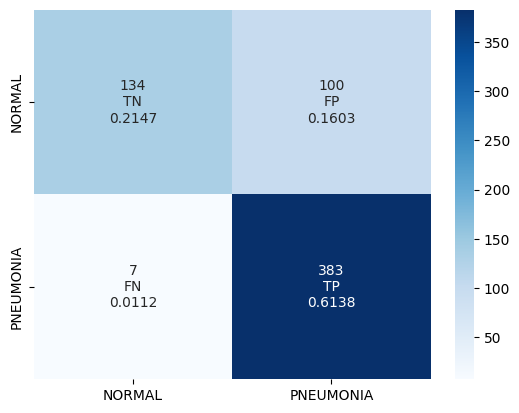

In [29]:
plot_confusion_matrix(model, test_data, true_labels)

In [30]:
model.evaluate(test_data, true_labels)

20/20 [==============================] - 0s 5ms/step - loss: 0.6415 - accuracy: 0.8285 - precision: 0.7930 - recall: 0.9821   


[0.6414755582809448,
 0.8285256624221802,
 0.7929606437683105,
 0.9820512533187866]